In [1]:
# Encoding
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
# models
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ploting
import seaborn as sns
import matplotlib.pyplot as plt

# utils
import pandas as pd
import numpy as np

import ast
from collections import defaultdict

## Data Loading

In [2]:
dataset = 'data/sncb_data_challenge.csv'
df = pd.read_csv(dataset, delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1011 non-null   int64  
 1   incident_id                   1011 non-null   int64  
 2   vehicles_sequence             1011 non-null   object 
 3   events_sequence               1011 non-null   object 
 4   seconds_to_incident_sequence  1011 non-null   object 
 5   approx_lat                    1011 non-null   float64
 6   approx_lon                    1011 non-null   float64
 7   train_kph_sequence            1011 non-null   object 
 8   dj_ac_state_sequence          1011 non-null   object 
 9   dj_dc_state_sequence          1011 non-null   object 
 10  incident_type                 1011 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 87.0+ KB


+ No missing values
+ sequences features

In [4]:
# Drop unused/irrelevant columns
df = df[['incident_type', 'events_sequence', 'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence']]

# convert strings representing lists into actual python lists
df['events_sequence'] = df['events_sequence'].apply(ast.literal_eval)
df['train_kph_sequence'] = df['train_kph_sequence'].apply(ast.literal_eval)
df['dj_ac_state_sequence'] = df['dj_ac_state_sequence'].apply(ast.literal_eval)
df['dj_dc_state_sequence'] = df['dj_dc_state_sequence'].apply(ast.literal_eval)

## EDA

In [5]:
df.head()

,incident_type,events_sequence,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence
0,4,"[2744, 4004, 2852, 4110, 2854, 4396, 1132, 414...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
1,13,"[2744, 4148, 4394, 1566, 1570, 4396, 3634, 412...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.1,...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
2,14,"[4394, 1566, 1570, 4114, 4168, 4168, 4156, 406...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, False, True, Tr..."
3,2,"[4066, 4066, 4066, 4066, 4068, 2742, 4026, 270...","[0.0, 0.0, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
4,14,"[4002, 4032, 4028, 2852, 4026, 4110, 2742, 285...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [6]:
df['incident_type'].value_counts()

incident_type
13    318
99    175
14    149
2     119
9     117
4      78
11     26
17     10
6       6
3       5
16      4
7       4
Name: count, dtype: int64

<Axes: xlabel='incident_type'>

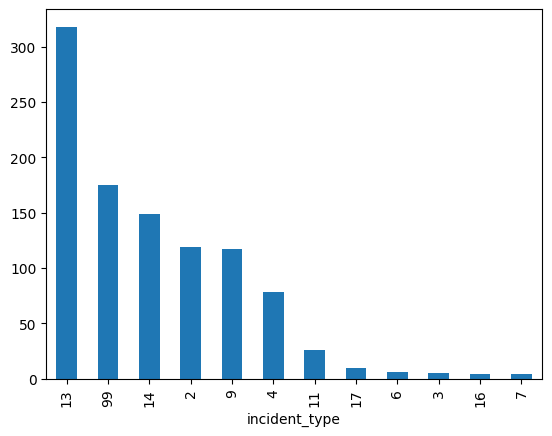

In [7]:
df['incident_type'].value_counts().plot(kind= 'bar')

Imbalanced  dataset

## Encodings
We consider the problem as a **text classification**, with the events sequence as tokenized texts.
We will try 2 encodings of this text:

+ tfidf
+ one-hot

In [8]:
def encode_df(sequences, method):
    
    documents = [' '.join(map(str, sequence)) for sequence in sequences]
    
    if method == 'tfidf':
        tv = TfidfVectorizer()
        tfidf_matrix = tv.fit_transform(documents)
        encoded_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"event_{feature}" for feature in tv.get_feature_names_out()])
        return encoded_df
    elif method == 'onehot':
        cv = CountVectorizer(binary=True)
        count_matrix = cv.fit_transform(documents)
        encoded_df = pd.DataFrame(count_matrix.toarray(), columns=[f"event_{feature}" for feature in cv.get_feature_names_out()])
        return encoded_df
    else:
        return None

## Model Evaluation

Must make sure we have relevant evaluation to correctly asses performances.

**4-fold stratified cross validation**:
+ cross validation since small dataset (train/test split risks being less reliable)
+ stratified since heavy imbalance, ensures each validation fold has same distribution so no minority class exclusion (more representative).
+ 4-fold since least populated class has only 4 records, even with stratified sampling ensures no minority class exclusion in validation folds (otherwise not representative)

**Metrics**:
+ f1-macro: each class equally important regardless of frequency
+ (accuracy: for informative purpose not used to asses perfromance, missleading due to heavy class imbalance)

In [9]:
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
}

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

def get_score(X, y, model, scoring=scoring, skf=skf):
    results = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
    f1_macro = results['test_f1_macro'].mean()
    accuracy = results['test_accuracy'].mean()
    return f1_macro, accuracy
    
def get_scores(X, y, names, models, scoring=scoring, skf=skf):
    scores_df = pd.DataFrame()
    accuracies = []
    macro_f1_scores = []

    for model in models:
        f1_macro, accuracy = get_score(X,y,model)
        macro_f1_scores.append(f1_macro)
        accuracies.append(accuracy)

    scores_df["Classifier"], scores_df["F1-macro"], scores_df["Accuracy"] = names, macro_f1_scores, accuracies
    scores_df.sort_values(by = 'F1-macro', ascending = False, inplace = True)
    return scores_df

## Baseline models on encodings

+ KNN
+ Multinomial NB
+ Bernoulli NB
+ Decision Tree
+ Random Forest
+ Linear SVC
+ XGBoost

In [10]:
# Classifiers
names = [
    "KNN",
    "Multinomial NB",
    "Bernoulli NB",
    "Decision Tree",
    "Random Forest",
    "Linear SVM",
    "XGBoost"
]

models = [
    KNeighborsClassifier(),
    MultinomialNB(),
    BernoulliNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=0),
    SVC(kernel = 'linear'),
    XGBClassifier(),
]

In [11]:
# different encodings
one_hot_df = encode_df(df['events_sequence'], 'onehot')
tfidf_df = encode_df(df['events_sequence'], 'tfidf')

# X/y
X_onehot = one_hot_df
X_tfidf = tfidf_df

y = LabelEncoder().fit_transform(df.incident_type)

In [13]:
get_scores(X_onehot, y, names, models)

,Classifier,F1-macro,Accuracy
6,XGBoost,0.357388,0.666710
5,Linear SVM,0.341002,0.628164
1,Multinomial NB,0.326718,0.628090
4,Random Forest,0.316847,0.651856
2,Bernoulli NB,0.309618,0.600422
3,Decision Tree,0.291015,0.557900
0,KNN,0.218250,0.490620


In [14]:
get_scores(X_tfidf, y, names, models)

,Classifier,F1-macro,Accuracy
6,XGBoost,0.351773,0.633078
2,Bernoulli NB,0.309618,0.600422
4,Random Forest,0.305150,0.631109
3,Decision Tree,0.264770,0.520277
0,KNN,0.198053,0.417420
5,Linear SVM,0.138976,0.399606
1,Multinomial NB,0.068726,0.344211


**Poor performances** due to noise (see eda - event distribution)

irrelevant and thus misleading information making harder for the model to learn the true patterns.

## Baseline models on encodings + noise filter
#### filter most informative individual events (relevance metric $r = \frac{h_{in\_class}}{h_{in\_all\_classes}}$)

In [12]:
# compute frequencies in dicts
def compute_frequencies():
    h_in_class = defaultdict(lambda: defaultdict(int)) # auto create new defaultdict(int) when new key accessed 
    h_in_all_classes = defaultdict(int)

    for index, row in df.iterrows():
        events_seq = row['events_sequence']
        incident = row['incident_type']
        for event in events_seq:
            h_in_class[event][incident]+=1
            h_in_all_classes[event]+=1
    
    return h_in_class, h_in_all_classes
    
def rel_metric(event, incident):
    return h_in_class[event][incident]/h_in_all_classes[event]

# filter events based on rel. metric r
def r_filter_df(t_r):
    h_in_class, h_in_all_classes = compute_frequencies()
    filtered_df = df.copy()
    filtered_df['events_sequence'] = df.apply(lambda row: [event for event in row['events_sequence'] if (h_in_class[event][row['incident_type']]/h_in_all_classes[event]) >= t_r], axis=1)
    return filtered_df

In [13]:
t_r = 0.13 # filter metric treshold (tuned by hand)
filtered_df = r_filter_df(t_r)

# different encodings
onehot_filt_df = encode_df(filtered_df['events_sequence'], 'onehot')
tfidf_filt_df = encode_df(filtered_df['events_sequence'], 'tfidf')

# X/y
X_onehot_filt = onehot_filt_df
X_tfidf_filt = tfidf_filt_df

In [51]:
get_scores(X_onehot_filt, y, names, models)

,Classifier,F1-macro,Accuracy
4,Random Forest,0.695602,0.969344
5,Linear SVM,0.658358,0.969340
3,Decision Tree,0.645778,0.948581
1,Multinomial NB,0.628533,0.969344
6,XGBoost,0.616154,0.964403
0,KNN,0.605413,0.930763
2,Bernoulli NB,0.531007,0.943641


In [52]:
get_scores(X_tfidf_filt, y, names, models)

,Classifier,F1-macro,Accuracy
4,Random Forest,0.696893,0.967376
3,Decision Tree,0.623331,0.934724
6,XGBoost,0.612110,0.953526
2,Bernoulli NB,0.531007,0.943641
0,KNN,0.478160,0.781381
5,Linear SVM,0.455786,0.753725
1,Multinomial NB,0.319784,0.691382


#### Noise filtering issue
 
Better performances but some sequences are filtered out leading do random guesses (bound f1 macro score)

In [14]:
filtered_out_df = filtered_df[filtered_df['events_sequence'].apply(len) == 0]
print(f"{filtered_out_df.shape[0]} events sequence filtered out with t_r = {t_r}")

13 events sequence filtered out with t_r = 0.13


<Axes: xlabel='incident_type'>

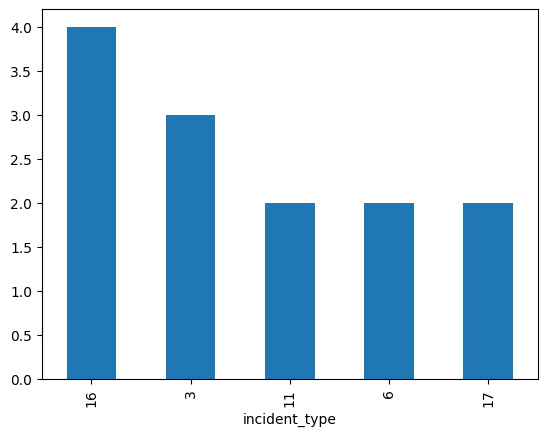

In [15]:
filtered_out_df['incident_type'].value_counts().plot(kind= 'bar')

Class '16' is even filtered out completely (4/4) !

## Random Forest on One-hot + noise filter + context features

Focus and best performing model, **random forest, and one-hot encoding** which aligns more with it (**effective splits** - tue or false)

First we get insight on random forest with one-hot encoding, by generating the **aggregate confusion matrix** of all k predictions (folds)

In [16]:
def cross_validation_conf_matrix(X, y, skf=skf):
    y_true_all = []
    y_pred_all = []
    
    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        clf = RandomForestClassifier(random_state=0)
        clf.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = clf.predict(X_test)
        
        # Store results
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Confusion Matrix:\n", cm)
    
    # Optional: Display classification report
    print("\nClassification Report:\n", classification_report(y_true_all, y_pred_all))

# use df['incident_type'] to get original incident ids instead of label encoded ones for readability
cross_validation_conf_matrix(X_onehot_filt, df['incident_type'])

Confusion Matrix:
 [[116   0   0   0   0   0   0   2   0   0   0   1]
 [  0   0   0   1   0   0   0   0   0   4   0   0]
 [  0   0  78   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   0   2   0   0   0   0   2   0   0]
 [  0   0   0   0   0 117   0   0   0   0   0   0]
 [  0   0   0   2   0   0  19   0   0   5   0   0]
 [  0   0   0   0   0   0   0 315   3   0   0   0]
 [  0   0   0   0   0   0   0   0 147   0   0   2]
 [  0   1   0   0   0   0   0   0   0   3   0   0]
 [  0   0   0   0   0   0   0   0   0   2   8   0]
 [  0   0   0   0   0   0   0   0   0   0   0 175]]

Classification Report:
               precision    recall  f1-score   support

           2       1.00      0.97      0.99       119
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00        78
           6       0.00      0.00      0.00         6
           7       1.00      0.50      0.67         4
           9      

#### Results analysis

class 3/6:
+ total failure

class 16:
+ low precision: records are missclassified as class 16
+ higher recall: 75% of class 16 records are detected

Observation: class 16 high recall can be explaned by the fact that it was completely filtered out, so an event sequence full of False is associated to this class, this is why classes 3 and 6 are missclassified (FP) as class 16 most of the times.

**Conclusions**:
Model struggles at identifying filtered out classes (3/6/16)

#### Add context features to have additional information for filtered out sequences.

+ speed
+ ac/dc states
+ vehicles

Context is introduced as encoded treshold features for same reason as onehot, that it performs best for tree based models (better splits).

In [17]:
# df['max_speed'] = df['train_kph_sequence'].apply(max)
# class_speeds = df.groupby('incident_type')['max_speed'].max()

# class_speeds.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
# plt.title("Average max speed by Incident Type")
# plt.xlabel("Incident Type")
# plt.ylabel("Average max Speed (kph)")
# plt.show()

In [18]:
import pandas as pd
import numpy as np

def categorize_speed(speed):
    if speed < 30:
        return 0
    elif speed < 50:
        return 1
    elif speed < 80:
        return 2
    else:
        return 3

def categorize_dj(dj_ratio):
    if dj_ratio < 0.1:
        return 0
    elif dj_ratio < 0.3:
        return 1
    elif dj_ratio < 0.5:
        return 2
    elif dj_ratio < 0.7:
        return 3
    else:
        return 4

def categorize_deviation(dev):
    return 0 if dev < 15 else 1

def gen_context_df(df):
    context_df = pd.DataFrame()

    # Add speed-related context features
    context_df['max_speed'] = df['train_kph_sequence'].apply(lambda x: categorize_speed(max(x)))
    
    context_df['min_speed'] = df['train_kph_sequence'].apply(lambda x: categorize_speed(min(x)))
    context_df['speed_dev'] = df['train_kph_sequence'].apply(lambda x: categorize_deviation(np.std(x)) if len(x) > 0 else categorize_deviation(0))
    
    # Add power source state features
    context_df['ac_state_ratio'] = df['dj_ac_state_sequence'].apply(lambda x: categorize_dj(sum(x)/len(x)))
    context_df['dc_state_ratio'] = df['dj_dc_state_sequence'].apply(lambda x: categorize_dj(sum(x)/len(x)))
    
    context_df['energy_switch'] = df.apply(lambda row: any(row['dj_ac_state_sequence']) and any(row['dj_dc_state_sequence']), axis=1)
    context_df['ac_state'] = df['dj_ac_state_sequence'].apply(lambda x: any(x))
    context_df['dc_state'] = df['dj_dc_state_sequence'].apply(lambda x: any(x))
    
    return context_df

TODO: treshold context to specificaly differentiate classss 3/6/16, through features distribution exploration (leakage ?)

In [25]:
# context features
context_df = gen_context_df(filtered_df)

# keep most relevant context features
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(context_df, y)
feature_importances = pd.Series(rf_clf.feature_importances_, index=context_df.columns)
low_importance_features = feature_importances[feature_importances < 0.1].index
print(f"Low importance features: {list(low_importance_features)}")
context_df = context_df.drop(columns=low_importance_features)

Low importance features: ['min_speed', 'speed_dev', 'energy_switch', 'ac_state', 'dc_state']


In [26]:
# X/y
X_onehot_filt_cntxt = pd.concat([onehot_filt_df, context_df], axis=1)

In [29]:
get_scores(X_onehot_filt_cntxt, y, ['OneHot'], [rf_clf])

,Classifier,F1-macro,Accuracy
0,OneHot,0.741584,0.976273


In [22]:
cross_validation_conf_matrix(X_onehot_filt_cntxt, df['incident_type'])

Confusion Matrix:
 [[117   0   0   0   0   0   0   1   0   0   0   1]
 [  0   0   0   1   0   0   1   0   0   3   0   0]
 [  0   0  78   0   0   0   0   0   0   0   0   0]
 [  0   1   0   2   0   0   0   0   0   3   0   0]
 [  0   1   0   0   2   0   0   0   0   1   0   0]
 [  0   0   0   0   0 117   0   0   0   0   0   0]
 [  0   3   0   0   0   0  21   0   0   2   0   0]
 [  0   0   0   0   0   0   0 316   2   0   0   0]
 [  0   0   0   0   0   0   0   0 147   0   0   2]
 [  0   0   0   0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   2   8   0]
 [  0   0   0   0   0   0   0   0   0   0   0 175]]

Classification Report:
               precision    recall  f1-score   support

           2       1.00      0.98      0.99       119
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00        78
           6       0.67      0.33      0.44         6
           7       1.00      0.50      0.67         4
           9      

Context leads to better performances as expected:
+ class 6 recall: 1/3 of class 6 records are detected (originally 0)
+ class 16 recall: every class 16 records correctly detected (originally 0.75)

Issue of class 3/6 miss classified as 16 still remaining.

#### Hyperparametre tune random forest

In [201]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [0]
}

rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=skf, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_onehot_filt_cntxt, y)

print("Best parameters:", grid_search.best_params_)
print("Best F1 Macro score:", grid_search.best_score_)

Fitting 4 folds for each of 216 candidates, totalling 864 fits


C:\Users\Hilal\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}
Best F1 Macro score: 0.7429697359699684


No major improvements

Solution: Better feature engeneering to handle class 16 precision, but risk of overfitting especially with minority classes.